In [ ]:
# BEFORE DOING ANYTHING
# cd Desktop
# git pull

# .. then do stuff ..
# git add .
# git commit -m "your message"
# git push

import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score, accuracy_score
import seaborn as sns
import time
from keras import models, layers, optimizers, regularizers
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
import xgboost as xgb
from xgboost import plot_importance

In [3]:
# The top 10 most important features are:
# How many people the property accommodates
# The cleaning fee
# How many other listings the host has (and whether they are a multi-listing host)
# How many days are available to book out of the next 90
# The fee per extra person
# The number of reviews
# The number of bathrooms
# The security deposit
# If the property is in Westminster
# The minimum nights stay


raw_df = pd.read_csv("listings.csv.gz")
# free text columns will be dropped for now
cols_to_drop = ['listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_verifications', 'calendar_last_scraped']
df = raw_df.drop(cols_to_drop, axis=1)

pd.set_option('display.max_columns', len(raw_df.columns)) # To view all columns
pd.set_option('display.max_rows', 100)

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df.isna().sum()
df.drop(["host_acceptance_rate", "neighbourhood_group_cleansed", "square_feet", "weekly_price", "monthly_price", 
         "license", "jurisdiction_names"], axis=1, inplace=True)

In [6]:
# host_listings_count and host_total_listings_count are the same in all but 16 cases. 
# These cases are those where the value is NaN. Therefore one of these columns can be dropped. 
print(sum((df.host_listings_count == df.host_total_listings_count) == False))
df.loc[((df.host_listings_count == df.host_total_listings_count) == False)][:]
df.drop(['host_total_listings_count', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes',
         'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms'], axis=1, inplace=True)


16


In [7]:
# Since all locations in Los Angeles, drop any columns related to location ie state, country
df["smart_location"].value_counts()
lat_long = df[["latitude", "longitude"]]
df.drop(["zipcode", "state", "country", "country_code", "street", "neighbourhood", "city", "latitude", "longitude", 
         "market", "smart_location", "is_location_exact"], axis=1, inplace= True)

In [8]:
# There are multiple columns for minimum and maximum night stays, 
# but the two main ones will be used as there are few differences between e.g. minimum_nights 
# and minimum_minimum_nights. The default (i.e. most frequently applied) min/max night stay values will be used instead.
sum((df.minimum_nights == df.minimum_minimum_nights) == False)
df.drop(['minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights',
         'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'], 
          axis=1, inplace=True)

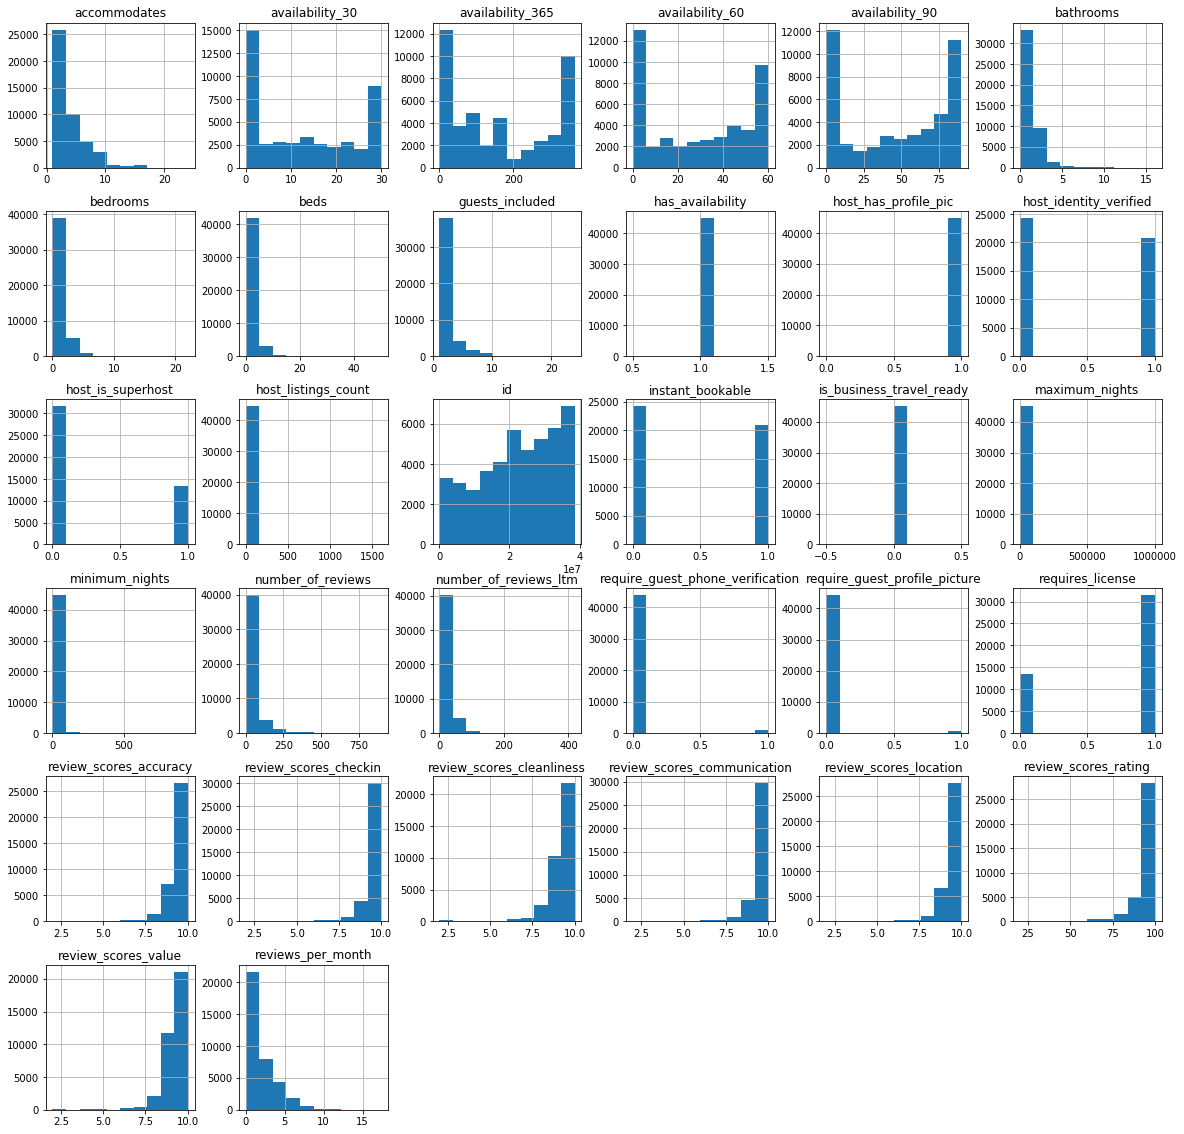

In [9]:
# Replacing columns with f/t with 0/1
df.replace({'f': 0, 't': 1}, inplace=True)

# Plotting the distribution of numerical and boolean categories
# df.hist(figsize=(20,20));

In [10]:
# Can see above that some boolean categories only contain one category and can be dropped:
df.drop(['has_availability', 'host_has_profile_pic', 'host_listings_count', 'is_business_travel_ready'], axis=1, inplace=True)

In [11]:
# Drop experiences_offered, 
print(df['experiences_offered'].value_counts())
df.drop('experiences_offered', axis=1, inplace=True)

none    45053
Name: experiences_offered, dtype: int64


In [12]:
# Now we're at 44 columns
print(df.shape)

(45053, 44)


In [13]:
###############################
## CLEANING INDIVIDUAL COLS ###
###############################

# host_since
# Converting to date time
df.host_since = pd.to_datetime(df.host_since)

# Calculating the number of days
df['host_days_active'] = (datetime(2019, 9, 14) - df.host_since).astype('timedelta64[D]')

# Printing mean and median
print("Mean days as host:", round(df['host_days_active'].mean(),0))
print("Median days as host:", df['host_days_active'].median())

# Replacing null values with the median
df.host_days_active.fillna(df.host_days_active.median(), inplace=True)


Mean days as host: 1448.0
Median days as host: 1417.0


In [14]:
# host_response_time

print("Null values:", df.host_response_time.isna().sum())

prop = round((df.host_response_time.isna().sum()/len(df))*100, 1)
print(f"Proportion: {prop}%")

# Number of rows without a value for host_response_time which have also not yet had a review
print(len(df[df.loc[ :,['host_response_time ', 'first_review'] ].isnull().sum(axis=1) == 2]))

df.host_response_time.fillna("unknown", inplace=True)
df.host_response_time.value_counts(normalize=True)


Null values: 8294
Proportion: 18.4%
8519


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


within an hour        0.600293
unknown               0.184094
within a few hours    0.120392
within a day          0.073513
a few days or more    0.021708
Name: host_response_time, dtype: float64

In [15]:
# host_response_rate
df.host_response_rate.value_counts()
print("Null values:", df.host_response_rate.isna().sum())
prop = round((df.host_response_rate.isna().sum()/len(df))*100, 1)
print(f"Proportion: {prop}%")


# Removing the % sign from the host_response_rate string and converting to an integer
df.host_response_rate = df.host_response_rate.str[:-1].astype('float64')

print("Mean host response rate:", round(df['host_response_rate'].mean(),0))
print("Median host response rate:", df['host_response_rate'].median())
prop_hund = round(((df.host_response_rate == 100.0).sum()/df.host_response_rate.count())*100,1)
print(f"Proportion of 100% host response rates: {prop_hund}%")

Null values: 8294
Proportion: 18.4%
Mean host response rate: 94.0
Median host response rate: 100.0
Proportion of 100% host response rates: 70.0%


In [16]:
# Bin into 4 categories 
df.host_response_rate = pd.cut(df.host_response_rate, bins=[0, 50, 90, 99, 100], labels=['0-49%', '50-89%', '90-99%', '100%'], include_lowest=True)

# Converting to string
df.host_response_rate = df.host_response_rate.astype('str')

# Replace nulls with 'unknown'
df.host_response_rate.replace('nan', 'unknown', inplace=True)

# Category counts
df.host_response_rate.value_counts()

100%       25726
unknown     8294
90-99%      5118
50-89%      4566
0-49%       1349
Name: host_response_rate, dtype: int64

In [17]:
# host_is_superhost

df.host_is_superhost.value_counts()

# There are 16 rows lacking values for each of five different host-related features.
# These rows will be dropped 
df[df.loc[ :,['host_since ', 'host_is_superhost', 'host_listings_count', 'host_has_profile_pic', 
                  'host_identity_verified'] ].isnull().sum(axis=1) == 5]

df.dropna(subset=['host_since'], inplace=True)

In [18]:
# property_type

# Replacing categories that are types of houses or apartments
df.property_type.replace({
    'Townhouse': 'House',
    'Serviced apartment': 'Apartment',
    'Loft': 'Apartment',
    'Bungalow': 'House',
    'Cottage': 'House',
    'Villa': 'House',
    'Tiny house': 'House',
    'Earth house': 'House',
    'Chalet': 'House'  
    }, inplace=True)

# Replacing other categories with 'other'
df.loc[~df.property_type.isin(['House', 'Apartment']), 'property_type'] = 'Other'

df.property_type.value_counts()

House        19390
Apartment    17872
Other         7775
Name: property_type, dtype: int64

In [19]:
# beds, bathrooms, bedrooms

# Replace missing values with the median
for col in ['bathrooms', 'bedrooms', 'beds']:
    df[col].fillna(df[col].median(), inplace=True)
    
# most listings have the same bed_type, so drop this
df.bed_type.value_counts()

df.drop('bed_type', axis=1, inplace=True)

In [20]:
# Amenities is a list of additional features in the property, e.g. whether it has a TV or parking.

# Create a set of all possible amenities
amenities_list = list(df.amenities)
amenities_list_string = " ".join(amenities_list)
amenities_list_string = amenities_list_string.replace('{', '')
amenities_list_string = amenities_list_string.replace('}', ',')
amenities_list_string = amenities_list_string.replace('"', '')
amenities_set = [x.strip() for x in amenities_list_string.split(',')]
amenities_set = set(amenities_set)
# amenities_set

In [21]:
# 44 cols to begin with
print(df.shape)

# Some amenities are more important than others, make new features for these (One Hot Encoding)
df.loc[df['amenities'].str.contains('24-hour check-in'), 'check_in_24h'] = 1
df.loc[df['amenities'].str.contains('Air conditioning|Central air conditioning'), 'air_conditioning'] = 1
df.loc[df['amenities'].str.contains('Amazon Echo|Apple TV|Game console|Netflix|Projector and screen|Smart TV'), 'high_end_electronics'] = 1
df.loc[df['amenities'].str.contains('BBQ grill|Fire pit|Propane barbeque'), 'bbq'] = 1
df.loc[df['amenities'].str.contains('Balcony|Patio'), 'balcony'] = 1
df.loc[df['amenities'].str.contains('Beach view|Beachfront|Lake access|Mountain view|Ski-in/Ski-out|Waterfront'), 'nature_and_views'] = 1
df.loc[df['amenities'].str.contains('Bed linens'), 'bed_linen'] = 1
df.loc[df['amenities'].str.contains('Breakfast'), 'breakfast'] = 1
df.loc[df['amenities'].str.contains('TV'), 'tv'] = 1
df.loc[df['amenities'].str.contains('Coffee maker|Espresso machine'), 'coffee_machine'] = 1
df.loc[df['amenities'].str.contains('Cooking basics'), 'cooking_basics'] = 1
df.loc[df['amenities'].str.contains('Dishwasher|Dryer|Washer'), 'white_goods'] = 1
df.loc[df['amenities'].str.contains('Elevator'), 'elevator'] = 1
df.loc[df['amenities'].str.contains('Exercise equipment|Gym|gym'), 'gym'] = 1
df.loc[df['amenities'].str.contains('Family/kid friendly|Children|children'), 'child_friendly'] = 1
df.loc[df['amenities'].str.contains('parking'), 'parking'] = 1
df.loc[df['amenities'].str.contains('Garden|Outdoor|Sun loungers|Terrace'), 'outdoor_space'] = 1
df.loc[df['amenities'].str.contains('Host greets you'), 'host_greeting'] = 1
df.loc[df['amenities'].str.contains('Hot tub|Jetted tub|hot tub|Sauna|Pool|pool'), 'hot_tub_sauna_or_pool'] = 1
df.loc[df['amenities'].str.contains('Internet|Pocket wifi|Wifi'), 'internet'] = 1
df.loc[df['amenities'].str.contains('Long term stays allowed'), 'long_term_stays'] = 1
df.loc[df['amenities'].str.contains('Pets|pet|Cat(s)|Dog(s)'), 'pets_allowed'] = 1
df.loc[df['amenities'].str.contains('Private entrance'), 'private_entrance'] = 1
df.loc[df['amenities'].str.contains('Safe|Security system'), 'secure'] = 1
df.loc[df['amenities'].str.contains('Self check-in'), 'self_check_in'] = 1
df.loc[df['amenities'].str.contains('Smoking allowed'), 'smoking_allowed'] = 1
df.loc[df['amenities'].str.contains('Step-free access|Wheelchair|Accessible'), 'accessible'] = 1
df.loc[df['amenities'].str.contains('Suitable for events'), 'event_suitable'] = 1

(45037, 44)


/usr/local/lib/python3.7/site-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [22]:
# Start at 44 because cols 44 thru 72 are the new amenity features

# Replacing nulls with zeros for new columns
cols_to_replace_nulls = df.iloc[:,44:].columns
df[cols_to_replace_nulls] = df[cols_to_replace_nulls].fillna(0)

# Produces a list of amenity features where one category (true or false) contains fewer than 10% of listings
infrequent_amenities = []
for col in df.iloc[:,44:].columns:
    if df[col].sum() < len(df)/10:
        infrequent_amenities.append(col)
print(infrequent_amenities)

# Dropping infrequent amenity features
df.drop(infrequent_amenities, axis=1, inplace=True)

# Dropping the original amenity feature
df.drop('amenities', axis=1, inplace=True)

['check_in_24h', 'high_end_electronics', 'nature_and_views', 'smoking_allowed', 'accessible', 'event_suitable']


In [23]:
df.columns[43:] # All the newly added features that we keep

Index(['air_conditioning', 'bbq', 'balcony', 'bed_linen', 'breakfast', 'tv',
       'coffee_machine', 'cooking_basics', 'white_goods', 'elevator', 'gym',
       'child_friendly', 'parking', 'outdoor_space', 'host_greeting',
       'hot_tub_sauna_or_pool', 'internet', 'long_term_stays', 'pets_allowed',
       'private_entrance', 'secure', 'self_check_in'],
      dtype='object')

In [24]:
# price

# Convert to integer
df.price = df.price.str[1:-3]
df.price = df.price.str.replace(",", "")
df.price = df.price.astype('int64')

In [25]:
# security_deposit

print(df.security_deposit.isna().sum())

# Having a missing security deposit is equivalent to having $0 security deposit

df.security_deposit = df.security_deposit.str[1:-3]
df.security_deposit = df.security_deposit.str.replace(",", "")
df.security_deposit.fillna(0, inplace=True)
df.security_deposit = df.security_deposit.astype('int64')

10903


In [26]:
# cleaning_fee

print(df.cleaning_fee.isna().sum())

# Having a missing cleaning fee is equivalent to having $0 cleaning fee
df.cleaning_fee = df.cleaning_fee.str[1:-3]
df.cleaning_fee = df.cleaning_fee.str.replace(",", "")
df.cleaning_fee.fillna(0, inplace=True)
df.cleaning_fee = df.cleaning_fee.astype('int64')

5866


In [27]:
# extra_people

# Having missing value for extra_people is equivalent to 0 extra people allowed
df.extra_people = df.extra_people.str[1:-3]
df.extra_people = df.extra_people.str.replace(",", "")
df.extra_people.fillna(0, inplace=True)
df.extra_people = df.extra_people.astype('int64')

In [28]:
# calendar_updated

df.calendar_updated.value_counts() 
# Unclear as to if this is useful; drop for now
df.drop('calendar_updated', axis=1, inplace=True)

In [29]:
# availability 
# ?? all are highly correlated, which to drop ??

# keep availability_90
df.drop(['availability_30', 'availability_60', 'availability_365'], axis=1, inplace=True)

In [30]:
# first_review and last_review

# Missing values should be kept as an 'unknown' category, and the feature will have to be treated as categorical 
# (and therefore one-hot encoded) rather than numerical.
# Keep missing values because this means it is probably a new listing !! so there's valuable info

print(f"Null values in 'first_review': {round(100*df.first_review.isna().sum()/len(df),1)}%")
print(f"Null values in 'review_scores_rating': {round(100*df.review_scores_rating .isna().sum()/len(df),1)}%")

df.first_review = pd.to_datetime(df.first_review) # Converting to datetime

# Calculating the number of days between the first review and the date the data was scraped
df['time_since_first_review'] = (datetime(2019, 9, 14) - df.first_review).astype('timedelta64[D]')

Null values in 'first_review': 18.9%
Null values in 'review_scores_rating': 20.2%


In [31]:
def bin_column(col, bins, labels, na_label='unknown'):
    """
    Takes in a column name, bin cut points and labels, replaces the original column with a
    binned version, and replaces nulls (with 'unknown' if unspecified).
    """
    df[col] = pd.cut(df[col], bins=bins, labels=labels, include_lowest=True)
    df[col] = df[col].astype('str')
    df[col].fillna(na_label, inplace=True)
    

In [32]:
# Binning time since first review
bin_column('time_since_first_review',
           bins=[0, 182, 365, 730, 1460, max(df.time_since_first_review)],
           labels=['0-6 months',
                   '6-12 months',
                   '1-2 years',
                   '2-3 years',
                   '4+ years'],
           na_label='no reviews')

In [33]:
# Do the same for last_review
df.last_review = pd.to_datetime(df.last_review) # Converting to datetime

# Calculating the number of days between the most recent review and the date the data was scraped
df['time_since_last_review'] = (datetime(2019, 9, 14) - df.last_review).astype('timedelta64[D]')

In [34]:
# Binning time since last review
bin_column('time_since_last_review',
           bins=[0, 14, 60, 182, 365, max(df.time_since_last_review)],
           labels=['0-2 weeks',
                   '2-8 weeks',
                   '2-6 months',
                   '6-12 months',
                   '1+ year'],
           na_label='no reviews')

In [35]:
# Dropping last_review - first_review will be kept for EDA and dropped later
df.drop('last_review', axis=1, inplace=True)

In [36]:
df.drop(['time_since_first_review', 'time_since_last_review'], axis=1, inplace=True)

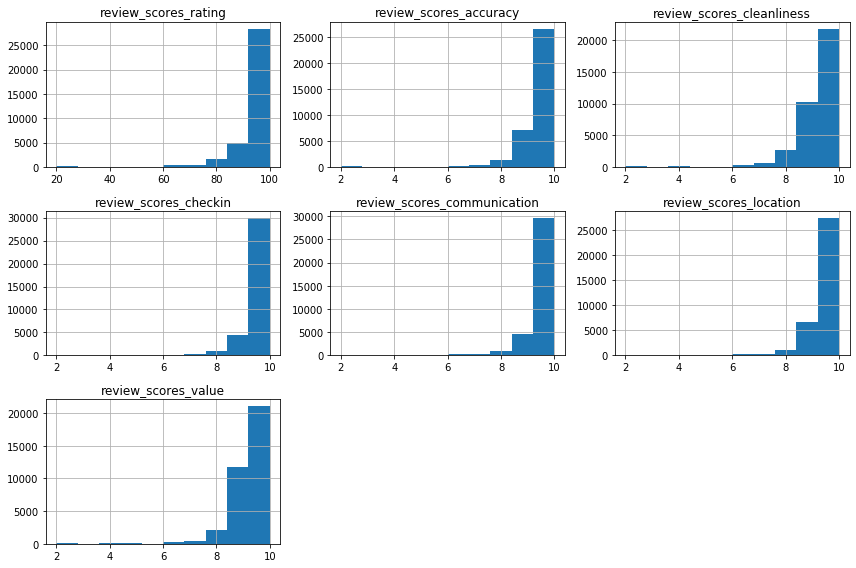

In [37]:
# Checking the distributions of the review ratings columns
variables_to_plot = list(df.columns[df.columns.str.startswith("review_scores") == True])
fig = plt.figure(figsize=(12,8))
for i, var_name in enumerate(variables_to_plot):
    ax = fig.add_subplot(3,3,i+1)
    df[var_name].hist(bins=10,ax=ax)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

In [38]:
variables_to_plot.pop(0)

'review_scores_rating'

In [39]:
# Binning for all columns scored out of 10
for col in variables_to_plot:
    bin_column(col,
               bins=[0, 8, 9, 10],
               labels=['0-8/10', '9/10', '10/10'],
               na_label='no reviews')

In [40]:
# Binning column scored out of 100
bin_column('review_scores_rating',
           bins=[0, 80, 95, 100],
           labels=['0-79/100', '80-94/100', '95-100/100'],
           na_label='no reviews')

In [41]:
# cancellation_policy
df.cancellation_policy.value_counts()

# Replacing categories
df.cancellation_policy.replace({
    'super_strict_30': 'strict_14_with_grace_period',
    'super_strict_60': 'strict_14_with_grace_period',
    'strict': 'strict_14_with_grace_period',
    'luxury_moderate': 'moderate',
    'luxury_no_refund': 'strict'
    }, inplace=True)

In [42]:
# Replacing other categories with 'other'
#df.loc[~df.property_type.isin(['House', 'Apartment']), 'property_type'] = 'Other'
values = df['neighbourhood_cleansed'].value_counts().keys().to_list()
counts = df['neighbourhood_cleansed'].value_counts().to_list()

low_values = []
for c in range(len(counts)):
    if counts[c] < 50:
        low_values.append(values[c])

# Replacing other categories with 'other'
df.loc[df.neighbourhood_cleansed.isin(low_values), 'neighbourhood_cleansed'] = 'Other'


In [43]:
df.drop('neighbourhood_cleansed', axis=1, inplace=True)

In [44]:
# Dropping features there were useless based on feature importance after Xgboost
df.drop(['number_of_reviews_ltm', 'reviews_per_month','review_scores_communication', 'cooking_basics', 'child_friendly', 'coffee_machine', 
         'outdoor_space', 'host_greeting', 'require_guest_profile_picture', 'secure', 
         'require_guest_phone_verification', 'host_since', 'first_review'], axis=1, inplace= True)

,id,host_response_time,host_response_rate,host_is_superhost,host_identity_verified,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_90,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_location,review_scores_value,requires_license,instant_bookable,cancellation_policy,host_days_active,air_conditioning,bbq,balcony,bed_linen,breakfast,tv,white_goods,elevator,gym,parking,hot_tub_sauna_or_pool,internet,long_term_stays,pets_allowed,private_entrance,self_check_in
26757,26577964,within an hour,100%,1.0,1.0,Apartment,Entire home/apt,2,1.0,16.0,1.0,159,500,129,1,15,1,1125,86,4,95-100/100,10/10,10/10,10/10,10/10,10/10,1,0,strict_14_with_grace_period,1881.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
34110,32171927,within an hour,100%,0.0,0.0,Apartment,Entire home/apt,2,1.0,22.0,1.0,96,0,38,1,25,1,300,85,14,0-79/100,0-8/10,0-8/10,0-8/10,0-8/10,0-8/10,1,1,strict_14_with_grace_period,348.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
42619,37431234,within an hour,90-99%,1.0,1.0,House,Entire home/apt,15,6.5,17.0,14.0,2600,4000,985,16,10,3,1125,90,0,nan,nan,nan,nan,nan,nan,1,0,strict_14_with_grace_period,2374.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0


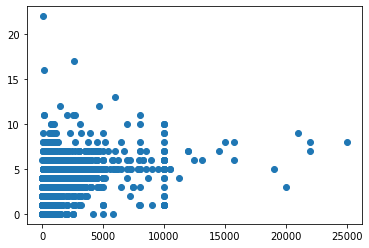

In [45]:
plt.plot(df.price, df.bedrooms, 'o')
df[df['bedrooms'] > 15]
# The first two rows are obviously an outliers/ data entered wrong, delete the rows

In [46]:
# The first two rows are obviously an outliers/ data entered wrong, delete the row
df.drop(26757, inplace = True)
df.drop(34110, inplace = True)

## Bin the Price Column
#### Use for linear associator model

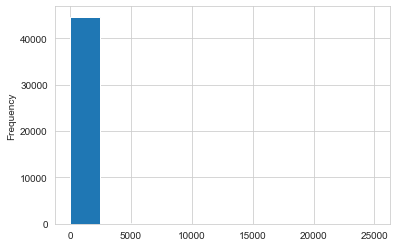

In [47]:
# Exploring how scores are distributed

df[df['price'] <= 50] # 6260
df[np.logical_and(df['price'] > 50, df['price'] <= 75)] # 7000
df[np.logical_and(df['price'] > 75, df['price'] <= 100)] # 8000
df[np.logical_and(df['price'] > 100, df['price'] <= 150)] # 9000
df[np.logical_and(df['price'] > 150, df['price'] <= 200)] # 5000
df[np.logical_and(df['price'] > 100, df['price'] <= 200)] # 13880
df[np.logical_and(df['price'] > 200, df['price'] <= 300)] # 3792
df[np.logical_and(df['price'] > 300, df['price'] <= 400)] # 1607
df[np.logical_and(df['price'] > 400, df['price'] <= 500)] # 929
df[np.logical_and(df['price'] > 500, df['price'] <= 600)] # 459
df[np.logical_and(df['price'] > 600, df['price'] <= 700)] # 316
df[np.logical_and(df['price'] > 700, df['price'] <= 1000)] # 718
df[df['price'] > 1000] # 1000

sns.set_style('whitegrid')
df['price'].plot(kind='hist')

In [49]:
bins = [0, 50, 75, 100, 150, 200, 300, 400, 500, 600, 700, 1000, max(df.price)]
labels = ['$0-50',
          '$50-75',
          '$75-100',
          '$100-150',
          '$150-200',
          '$200-300',
          '$300-400', 
          '$400-500', 
          '$500-600',
          '$600-700', 
          '$700-1000',
          '$1000+']
na_label = 'no price'

df_p = df.copy() # save for later when need price bins
df_p['price_bin'] = pd.cut(df_p['price'], bins=bins, labels=labels, include_lowest=True)
# df['price'].plot(kind='hist', bins = bins)

### Preparing the data for modeling

In [50]:
transformed_df = pd.get_dummies(df)

## Do heatmap later, possibly drop some


In [220]:
numerical_columns = ['accommodates', 'availability_90', 'bathrooms', 'beds', 'bedrooms','cleaning_fee', 'extra_people', 
                     'host_days_active', 'maximum_nights', 'minimum_nights', 
                     'number_of_reviews', 'price', 'security_deposit']

# Log transforming columns
numerical_columns = [i for i in numerical_columns if i not in ['availability_90', 'host_days_active']] # Removing items not to be transformed

for col in numerical_columns:
    transformed_df[col] = transformed_df[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
    transformed_df[col] = np.log(transformed_df[col])

In [221]:
transformed_df

,id,host_is_superhost,host_identity_verified,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_90,number_of_reviews,requires_license,instant_bookable,host_days_active,air_conditioning,bbq,balcony,bed_linen,breakfast,tv,white_goods,elevator,gym,parking,hot_tub_sauna_or_pool,internet,long_term_stays,pets_allowed,private_entrance,self_check_in,host_response_time_a few days or more,host_response_time_unknown,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_response_rate_0-49%,host_response_rate_100%,host_response_rate_50-89%,host_response_rate_90-99%,host_response_rate_unknown,property_type_Apartment,property_type_House,property_type_Other,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,review_scores_rating_0-79/100,review_scores_rating_80-94/100,review_scores_rating_95-100/100,review_scores_rating_nan,review_scores_accuracy_0-8/10,review_scores_accuracy_10/10,review_scores_accuracy_9/10,review_scores_accuracy_nan,review_scores_cleanliness_0-8/10,review_scores_cleanliness_10/10,review_scores_cleanliness_9/10,review_scores_cleanliness_nan,review_scores_checkin_0-8/10,review_scores_checkin_10/10,review_scores_checkin_9/10,review_scores_checkin_nan,review_scores_location_0-8/10,review_scores_location_10/10,review_scores_location_9/10,review_scores_location_nan,review_scores_value_0-8/10,review_scores_value_10/10,review_scores_value_9/10,review_scores_value_nan,cancellation_policy_flexible,cancellation_policy_luxury_super_strict_95,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period
0,109,0.0,1.0,1.791759,0.693147,0.693147,1.098612,4.804021,6.214608,5.480639,3,3.218876,3.401197,6.593045,0,0.693147,0,0,4096.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1
1,344,0.0,1.0,1.791759,0.000000,1.098612,1.098612,5.123964,-4.605170,4.605170,6,-4.605170,0.693147,2.639057,0,1.791759,0,1,4082.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0
2,2708,1.0,1.0,0.000000,0.405465,0.000000,0.000000,4.369448,6.173786,4.465908,1,-4.605170,3.332205,5.902633,1,3.044522,1,1,4015.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1
3,2732,1.0,0.0,0.000000,0.000000,0.000000,0.000000,4.941642,-4.605170,4.605170,1,-4.605170,0.000000,5.192957,71,2.944439,1,0,4014.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
4,2864,0.0,1.0,0.693147,0.000000,0.000000,0.000000,4.382027,4.605170,4.317488,1,3.218876,0.693147,6.593045,0,-4.605170,0,0,4006.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45048,38603385,0.0,0.0,0.000000,0.000000,-4.605170,0.000000,4.488636,-4.605170,-4.605170,1,-4.605170,0.000000,7.025538,83,-4.605170,1,0,518.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0
45049,38603626,1.0,1.0,0.693147,0.000000,0.000000,0.000000,4.499810,-4.605170,3.218876,1,-4.605170,1.098612,7.025538,90,-4.605170,1,1,1125.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,

## XGBoost 

In [50]:
# Separating X and y
X = transformed_df.drop('price', axis=1)
y = transformed_df.price

# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)


0        122.0
1        168.0
2         79.0
3        140.0
4         80.0
         ...  
45048     89.0
45049     90.0
45050     47.0
45051    105.0
45052     28.0
Name: price, Length: 45037, dtype: float64


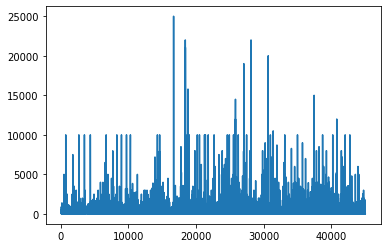

In [139]:
plt.plot(np.exp(y))

In [51]:
xgb_reg_start = time.time()

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14:44:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Time taken to run: 0.3 minutes

Training MSE: 0.1887
Validation MSE: 0.1827

Training r2: 0.7529
Validation r2: 0.757


In [52]:
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

print(np.exp(val_preds_xgb_reg))
print(np.exp(y_test))

[  94.89442   109.47548  2160.7563   ...   69.27786    54.883656
   98.97933 ]
3551       79.0
21623     150.0
26739    1950.0
18843      60.0
2492       88.0
          ...  
19592     105.0
35259     299.0
14359      66.0
2803       45.0
40017     105.0
Name: price, Length: 9008, dtype: float64


In [53]:
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', inplace=True)
#ft_weights_xgb_reg


,weight
host_response_rate_0-49%,0.000000
host_response_time_a few days or more,0.000000
host_response_time_within a day,0.000000
cancellation_policy_strict,0.000000
host_response_rate_50-89%,0.000000
host_response_rate_unknown,0.000000
property_type_Other,0.000000
review_scores_rating_0-79/100,0.000000
review_scores_rating_95-100/100,0.000000
review_scores_rating_nan,0.000000


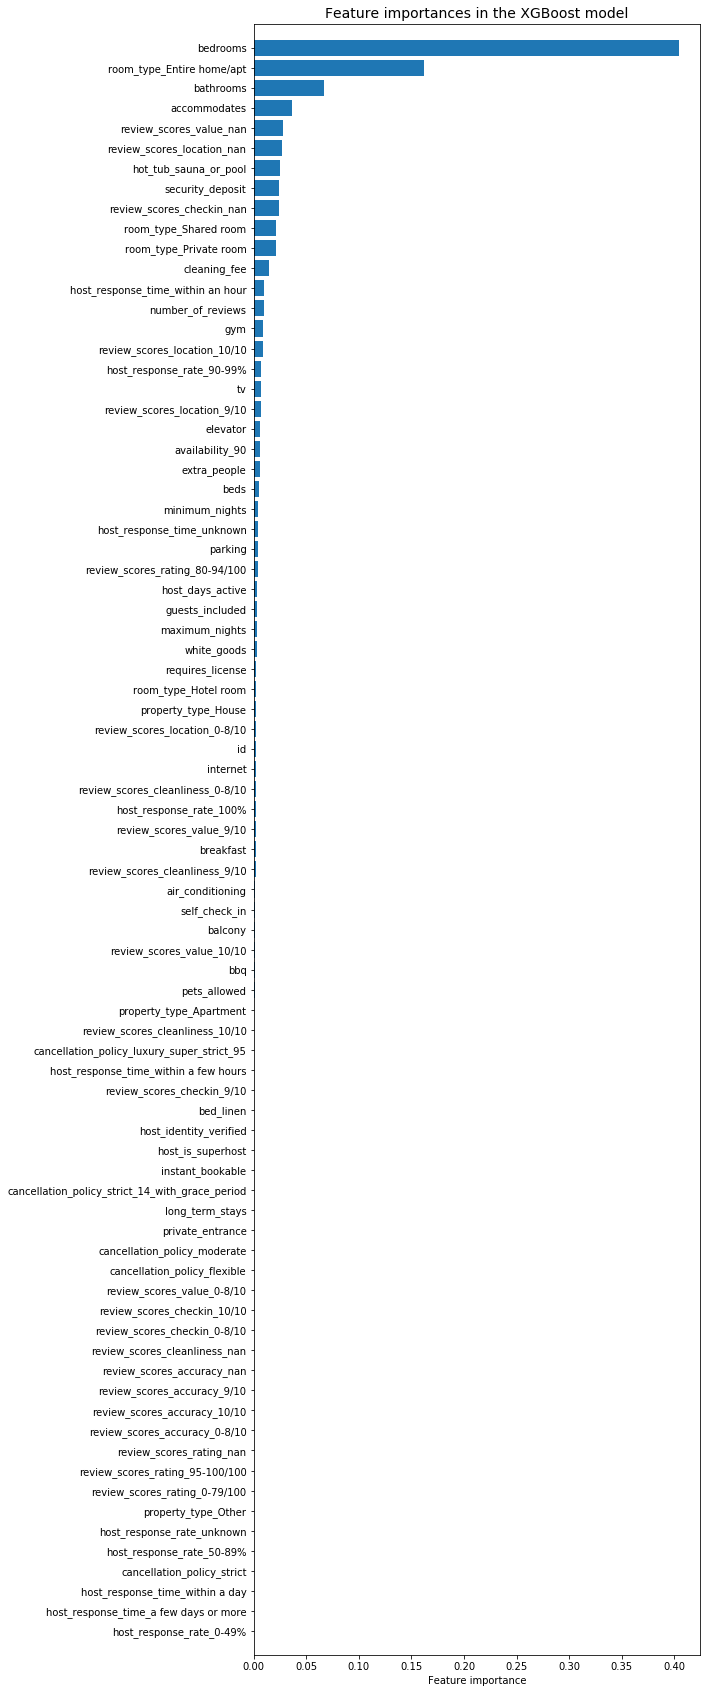

In [54]:
# Plotting feature importances
plt.figure(figsize=(8,30))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

## NEURAL NETWORK: 

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               10368     
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_7 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total params: 109,441
Trainable params: 109,441
Non-trainable params: 0
_________________________________________________________________
None


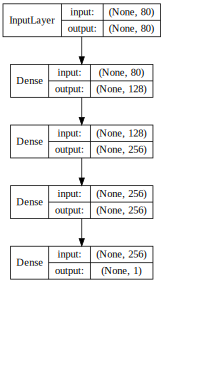

In [56]:

# Building the model
nn2 = models.Sequential()
nn2.add(layers.Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
nn2.add(layers.Dense(256, activation='relu'))
nn2.add(layers.Dense(256, activation='relu'))
nn2.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn2.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn2.summary())

# Visualising the neural network
SVG(model_to_dot(nn2, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

In [57]:
# Training the model
nn2_start = time.time()

nn2_history = nn2.fit(X_train,
                  y_train,
                  epochs=100,
                  batch_size=256,
                  validation_split = 0.1)

nn2_end = time.time()

print(f"Time taken to run: {round((nn2_end - nn2_start)/60,1)} minutes")

Train on 32426 samples, validate on 3603 samples
Epoch 1/100
32426/32426 [==============================] - 2s 53us/step - loss: 1.1815 - mean_squared_error: 1.1815 - val_loss: 0.2783 - val_mean_squared_error: 0.2783
Epoch 2/100
32426/32426 [==============================] - 1s 34us/step - loss: 0.2701 - mean_squared_error: 0.2701 - val_loss: 0.2366 - val_mean_squared_error: 0.2366
Epoch 3/100
32426/32426 [==============================] - 1s 36us/step - loss: 0.2361 - mean_squared_error: 0.2361 - val_loss: 0.2184 - val_mean_squared_error: 0.2184
Epoch 4/100
32426/32426 [==============================] - 1s 35us/step - loss: 0.2183 - mean_squared_error: 0.2183 - val_loss: 0.2106 - val_mean_squared_error: 0.2106
Epoch 5/100
32426/32426 [==============================] - 1s 34us/step - loss: 0.2060 - mean_squared_error: 0.2060 - val_loss: 0.2067 - val_mean_squared_error: 0.2067
Epoch 6/100
32426/32426 [==============================] - 1s 34us/step - loss: 0.1957 - mean_squared_error: 0.

32426/32426 [==============================] - 1s 28us/step - loss: 0.0159 - mean_squared_error: 0.0159 - val_loss: 0.2440 - val_mean_squared_error: 0.2440
Epoch 98/100
32426/32426 [==============================] - 1s 31us/step - loss: 0.0171 - mean_squared_error: 0.0171 - val_loss: 0.2469 - val_mean_squared_error: 0.2469
Epoch 99/100
32426/32426 [==============================] - 1s 29us/step - loss: 0.0149 - mean_squared_error: 0.0149 - val_loss: 0.2479 - val_mean_squared_error: 0.2479
Epoch 100/100
32426/32426 [==============================] - 1s 30us/step - loss: 0.0155 - mean_squared_error: 0.0155 - val_loss: 0.2429 - val_mean_squared_error: 0.2429
Time taken to run: 2.0 minutes


In [58]:
def nn_model_evaluation(model, skip_epochs=0, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    """
    For a given neural network model that has already been fit, prints for the train and tests sets the MSE and r squared
    values, a line graph of the loss in each epoch, and a scatterplot of predicted vs. actual values with a line
    representing where predicted = actual values. 
    """

    # MSE and r squared values
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    print("Training MSE:", round(mean_squared_error(y_train, y_train_pred),4))
    print("Validation MSE:", round(mean_squared_error(y_test, y_test_pred),4))
    print("\nTraining r2:", round(r2_score(y_train, y_train_pred),4))
    print("Validation r2:", round(r2_score(y_test, y_test_pred),4))
    
    # Line graph of losses
    model_results = model.history.history
    plt.plot(list(range((skip_epochs+1),len(model_results['loss'])+1)), model_results['loss'][skip_epochs:], label='Train')
    plt.plot(list(range((skip_epochs+1),len(model_results['val_loss'])+1)), model_results['val_loss'][skip_epochs:], label='Test', color='green')
    plt.legend()
    plt.title('Training and test loss at each epoch', fontsize=14)
    plt.show()
    
    # Scatterplot of predicted vs. actual values
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle('Predicted vs. actual values', fontsize=14, y=1)
    plt.subplots_adjust(top=0.93, wspace=0)
    ax1.scatter(y_test, y_test_pred, s=2, alpha=0.7)
    ax1.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
    ax1.set_title('Test set')
    ax1.set_xlabel('Actual values')
    ax1.set_ylabel('Predicted values')
    
    ax2.scatter(y_train, y_train_pred, s=2, alpha=0.7)
    ax2.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
    ax2.set_title('Train set')
    ax2.set_xlabel('Actual values')
    ax2.set_ylabel('')
    ax2.set_yticklabels(labels='')
    
    plt.show()

Training MSE: 0.0363
Validation MSE: 0.2651

Training r2: 0.9525
Validation r2: 0.6473


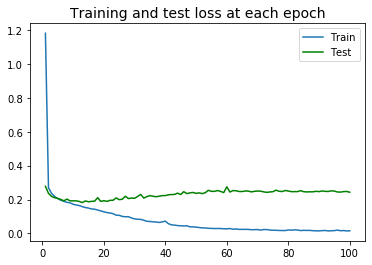

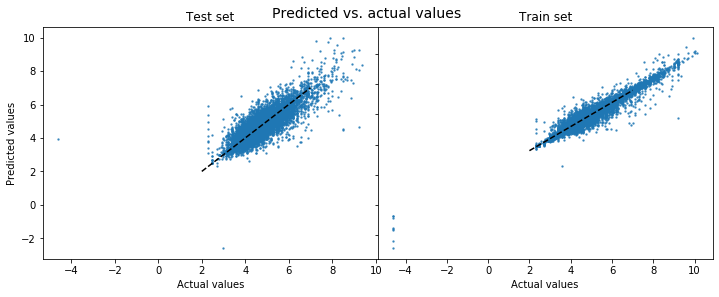

In [59]:
nn_model_evaluation(nn2)


In [51]:
# X_train = train_X
# y_train
y_train.shape

NameError: name 'y_train' is not defined

In [52]:
#######################
## HELPER FUNCTIONS  ##
#######################

def is_fully_corrupted(string):
    if re.match(r'^[_]+$', string):
        return True
def is_partial_corrupted(string):
    if re.match(r'^[_]+[^_]+$', string): # front
        return True
    if re.match(r'^[^_]+[_]+$', string):  # end
        return True
    if re.match(r'^[^_]+[_]+[^_]+$', string): # middle
        return True
    else:
        return False
    
def has_number(string):
    return any(char.isdigit() for char in string)

# Multiplies a scalar and vectors
def scalar_times_vector(scalar, a, dim):
    B = np.zeros(dim)
    for i in range(dim):
        B[i] = scalar * a[i]
    return B

# Widrow Hoff learning rule 
def Widrow_Hoff(k, g, g_prime, f, dim):
    length_f = np.linalg.norm(f)
    difference_vector = np.subtract(g, g_prime)
    weighted_vector = k * difference_vector
    deltaA = np.outer(g, np.transpose(f))
    return deltaA, weighted_vector

### Get Data Ready for Modeling

In [53]:
# df['price_bins'] holds the price bins
# Need to binary encode
y = df_p['price_bin']
df_p.drop('price_bin', axis=1, inplace=True)

transformed_df = pd.get_dummies(df_p)

numerical_columns = ['accommodates', 'availability_90', 'bathrooms', 'beds', 'bedrooms','cleaning_fee', 'extra_people', 
                     'host_days_active', 'maximum_nights', 'minimum_nights', 
                     'number_of_reviews', 'price', 'security_deposit']

# Log transforming columns
numerical_columns = [i for i in numerical_columns if i not in ['availability_90', 'host_days_active']] # Removing items not to be transformed

for col in numerical_columns:
    transformed_df[col] = transformed_df[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
    transformed_df[col] = np.log(transformed_df[col])
    
# Separating X and y
X = transformed_df.drop('price', axis=1)

# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)


In [77]:
print(X_train.shape)
print(y_train.shape)

(36028, 80)
(36028,)


In [60]:
train_X = []
n = X_train.shape[0] # The number of ROWS
print("Number of rows: ", n)
dim = X_train.shape[1] # The number of COLUMNS (features)
print("Number of features (cols): ", dim)

for key,value in X_train.iterrows():
    f = value.to_numpy()
    f = f.reshape((dim,1))
    # Center and Scale
    f = f - f.mean()
    f = f / np.linalg.norm(f)
    train_X.append(f)
    
# y_train needs to be array of arrays
target = []
G_set = y_train.values
print(G_set)
for i in range(y_train.shape[0]):
    if G_set[i] == '$0-50':
        target.append(np.array([1,0,0,0,0,0,0,0,0,0,0,0]).reshape(12,1))
    elif G_set[i] == '$50-75':
        target.append(np.array([0,1,0,0,0,0,0,0,0,0,0,0]).reshape(12,1))
    elif G_set[i] == '$75-100':
        target.append(np.array([0,0,1,0,0,0,0,0,0,0,0,0]).reshape(12,1))
    elif G_set[i] == '$100-150':
        target.append(np.array([0,0,0,1,0,0,0,0,0,0,0,0]).reshape(12,1))
    elif G_set[i] == '$150-200':
        target.append(np.array([0,0,0,0,1,0,0,0,0,0,0,0]).reshape(12,1))
    elif G_set[i] == '$200-300':
        target.append(np.array([0,0,0,0,0,1,0,0,0,0,0,0]).reshape(12,1))
    elif G_set[i] == '$300-400':
        target.append(np.array([0,0,0,0,0,0,1,0,0,0,0,0]).reshape(12,1))
    elif G_set[i] == '$400-500':
        target.append(np.array([0,0,0,0,0,0,0,1,0,0,0,0]).reshape(12,1))
    elif G_set[i] == '$500-600':
        target.append(np.array([0,0,0,0,0,0,0,0,1,0,0,0]).reshape(12,1))
    elif G_set[i] == '$600-700':
        target.append(np.array([0,0,0,0,0,0,0,0,0,1,0,0]).reshape(12,1))
    elif G_set[i] == '$700-1000':
        target.append(np.array([0,0,0,0,0,0,0,0,0,0,1,0]).reshape(12,1))
    elif G_set[i] == '$1000+':
        target.append(np.array([0,0,0,0,0,0,0,0,0,0,0,1]).reshape(12,1))
        
target_X = []
for g in target:
    MEAN = g.mean()
    LENGTH = np.linalg.norm(g)
    g = g - g.mean()
    g = g / np.linalg.norm(g)
    target_X.append(g)
    

Number of rows:  36028
Number of features (cols):  80
[$200-300, $50-75, $400-500, $0-50, $0-50, ..., $100-150, $150-200, $75-100, $100-150, $200-300]
Length: 36028
Categories (12, object): [$0-50 < $50-75 < $75-100 < $100-150 ... $500-600 < $600-700 < $700-1000 < $1000+]


In [ ]:
print(len(train_X))
print(len(target_X))

In [65]:
##########################
## WIDROW-HOFF LEARNING ##
#########################

dim = len(train_X) # NUMBER OF ROWS
n =  80 # NUMBER OF FEATURES (COLS)
m = 12 # NUMBER OF ROWS IN TARGET VALUES
A_i = [ np.outer(target_X[i], np.transpose(train_X[i])) for i in range(dim) ]

# Form the overall connectivity matrix A
# INITTIAL A MATRIX: 4x17
A = np.zeros((m,n))
for i in range(dim):
    A = np.add(A, A_i[i])
print(A.shape)
# Compute the output for each stored vector fi
G_prime = [ A.dot(train_X[i]) for i in range(dim) ]
print(len(G_prime))

learned = np.zeros(dim)
count = 0
converged = False
oscillate_input = False
errorThreshold = 0.01;
Errors = []
k = 0.85

# Choose random pairs and store in array
randints = np.random.choice(20,20, replace=False)

while converged == False:
    mse = 0
    # Pick a random pair of f and g vectors
    r = randints[count]
    f = train_X[r]
    g = target_X[r]
    g_prime = A.dot(f)
    learned[count] = 1
    
    #new_error = np.linalg.norm(error)
    deltaA, error = Widrow_Hoff(k, g, g_prime, f, dim)
    A = np.add(A, deltaA)
    error_length = np.linalg.norm(error)
    Errors.append(error_length)

    print("Current Error:", error_length)
    
    #if (abs(np.linalg.norm(error) - new_error) / np.linalg.norm(error) < errorThreshold) and (sum(learned) == n):
    if (abs(error_length) < errorThreshold):
        print("Error: ", abs(error_length))
        print("Error Threshold: ", errorThreshold)
        print("Number of trials: ", count)
        converged = True
        
    count = count + 1;
    k =  k - .05

(12, 80)
36028
Current Error: 183.31538563759779
Current Error: 538.681548515098
Current Error: 606.6158197618403
Current Error: 274.3178364905021
Current Error: 479.6263351926586
Current Error: 378.9812606607701
Current Error: 501.6184737207563
Current Error: 498.0868458039925
Current Error: 355.66156725648824
Current Error: 45.732056558789346
Current Error: 155.97283499467497
Current Error: 289.8280745228279
Current Error: 200.8630009120231
Current Error: 116.47156420094814
Current Error: 87.73940085300588
Current Error: 92.48739097802607
Current Error: 38.07798642831801
Current Error: 1.1640598621324337e-13
Error:  1.1640598621324337e-13
Error Threshold:  0.01
Number of trials:  17


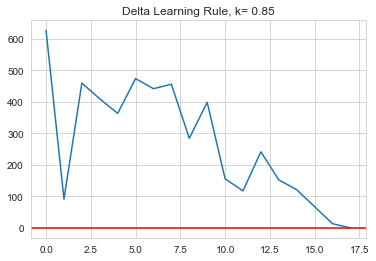

In [58]:
plt.plot(Errors,'-')
plt.axhline(y=0,color="red")
plt.title("Delta Learning Rule, k= 0.85")
plt.show()

In [ ]:
##################################
## CLASSIFICATIONS FOR TRAINING ##
##################################
# Now get target values again:

G_prime = [ A.dot(train_X[i]) for i in range(dim) ]

y_pred = []
for g in G_prime:
    target = g*LENGTH + MEAN
    # The max arg represents the classification of price
    max_arg = np.argmax(target)
    if max_arg == 0:
        price_bin = '$0-50'
    elif max_arg == 1:
        price_bin = '$50-75'
    elif max_arg == 2:
        price_bin = '$75-100'
    elif max_arg == 3:
        price_bin = '$100-150'
    elif max_arg == 4:
        price_bin = '$150-200'
    elif max_arg == 5: 
        price_bin = '$200-300'
    elif max_arg == 4:
        price_bin = '$300-400'
    elif max_arg == 4:
        price_bin = '$400-500'
    elif max_arg == 4:
        price_bin = '$500-600'
    elif max_arg == 4:
        price_bin = '$600-700'
    elif max_arg == 4:
        price_bin = '$700-800'
        
    y_pred.append(price_bins)